In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import time

# Load and preprocess the dataset
df = pd.read_csv("https://archive.ics.uci.edu/static/public/891/data.csv")
df = df.drop(columns=["ID"])

X = df.drop(columns=["Diabetes_binary"]).values
y = df["Diabetes_binary"].values

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

# Define Neural Network model
class DiabetesNet(nn.Module):
    def __init__(self):
        super(DiabetesNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiabetesNet().to(device)

# Loss and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
start = time.time()
for epoch in range(20):
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
end = time.time()

# Evaluate
with torch.no_grad():
    model.eval()
    preds = model(X_test_t.to(device)).squeeze()
    preds_class = (preds > 0.5).float()
    acc = (preds_class == y_test_t.to(device)).float().mean().item()
    print("PyTorch Neural Network")
    print(f"Accuracy: {acc:.4f}")
    print(f"Training time: {end - start:.4f} seconds")


PyTorch Neural Network
Accuracy: 0.8651
Training time: 104.8969 seconds


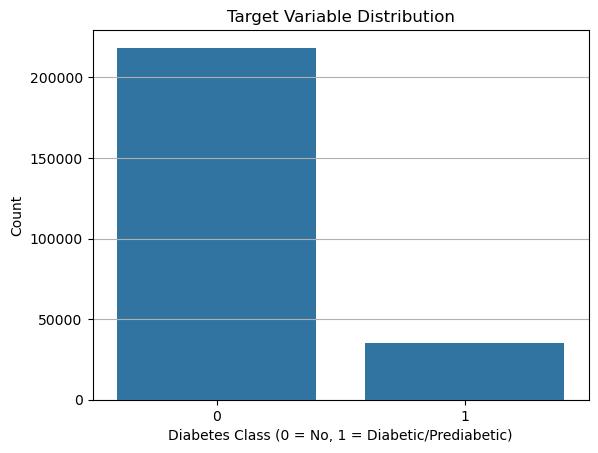

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df["Diabetes_binary"])
plt.title("Target Variable Distribution")
plt.xlabel("Diabetes Class (0 = No, 1 = Diabetic/Prediabetic)")
plt.ylabel("Count")
plt.grid(axis="y")
plt.savefig("dataset_target_distribution.png", dpi=300)  # Save here
plt.show()